In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression

# Load dataset
df = pd.read_csv('data.csv', parse_dates=['timestamp'])

# Feature engineering from timestamp
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df = df.drop('timestamp', axis=1)

# Handle missing values if any
df = df.dropna()

In [171]:
print("\n converting Timestamp to DateTime")
# converting the timestamp column to datatime as it is object
if 'timestamp' in df.columns:
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    print("Timestamp converted to datetime format")
    

# fixing numeric columns stored as objects
object_cols = [
    'equipment_energy_consumption',
    'lighting_energy',
    'zone1_temperature',
    'zone1_humidity',
    'zone2_temperature'
]

for col in object_cols:
    # if there is any characters first we are replacing it with empty
    df[col] = df[col].str.replace('[^\d.]', '', regex=True)
    # then convert to float
    df[col] = pd.to_numeric(df[col], errors='coerce')



# Define the function to replace negative values with NaN
def set_negative_to_nan(series):
    return series.where(series >= 0, np.nan)

# Columns where negative values are invalid
columns_to_clean = [col for col in df.columns if 'humidity' in col.lower()] + ['wind_speed', 'visibility_index']

# Apply the function to these columns
df[columns_to_clean] = df[columns_to_clean].apply(set_negative_to_nan)


 converting Timestamp to DateTime


<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
C:\Users\knj93\AppData\Local\Temp\ipykernel_11132\203182202.py:20: SyntaxWarning: invalid escape sequence '\d'
  df[col] = df[col].str.replace('[^\d.]', '', regex=True)


## High energy analysis enrgy > 250

In [139]:
df.isnull().sum()

equipment_energy_consumption    0
lighting_energy                 0
zone1_temperature               0
zone1_humidity                  0
zone2_temperature               0
zone2_humidity                  0
zone3_temperature               0
zone3_humidity                  0
zone4_temperature               0
zone4_humidity                  0
zone5_temperature               0
zone5_humidity                  0
zone6_temperature               0
zone6_humidity                  0
zone7_temperature               0
zone7_humidity                  0
zone8_temperature               0
zone8_humidity                  0
zone9_temperature               0
zone9_humidity                  0
outdoor_temperature             0
atmospheric_pressure            0
outdoor_humidity                0
wind_speed                      0
visibility_index                0
dew_point                       0
random_variable1                0
random_variable2                0
hour                            0
day_of_week   

In [151]:
df[target].dtype
high_energy_data = df[df[target] > 250]

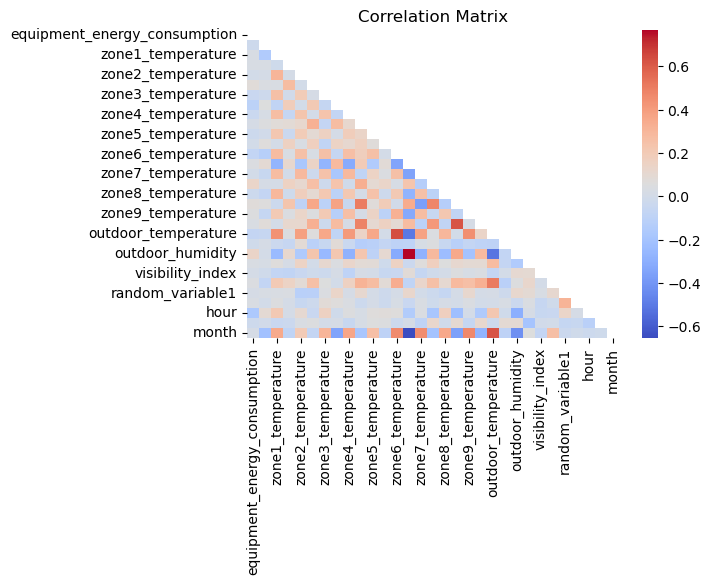


Top Correlated Features:
outdoor_humidity     0.139515
zone7_humidity       0.129377
zone2_humidity       0.075357
zone8_humidity       0.071302
zone9_temperature    0.050299
Name: equipment_energy_consumption, dtype: float64

Mutual Information Scores:
zone9_humidity          0.120430
hour                    0.112228
zone1_humidity          0.065765
zone8_temperature       0.062361
zone7_temperature       0.060177
zone5_temperature       0.057074
zone3_humidity          0.045022
atmospheric_pressure    0.043629
zone4_humidity          0.043500
zone8_humidity          0.041746
dtype: float64


In [155]:
df =high_energy_data.copy()
# Separate features and target
X = df.drop('equipment_energy_consumption', axis=1)
y = df['equipment_energy_consumption']

# 1. Correlation Analysis
corr_matrix = df.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', 
            mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title('Correlation Matrix')
plt.savefig('high_energy_corr.png')
plt.show()

# Top correlated features with target
target_corr = corr_matrix['equipment_energy_consumption'].sort_values(ascending=False)
print("\nTop Correlated Features:")
print(target_corr[1:6])  # Exclude self-correlation

# 2. Mutual Information Analysis
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print("\nMutual Information Scores:")
print(mi_series.head(10))


Feature Importances:
hour                    0.208470
random_variable2        0.058085
zone5_humidity          0.045308
random_variable1        0.038283
zone7_humidity          0.037668
zone1_temperature       0.037483
zone3_humidity          0.035785
dew_point               0.035062
atmospheric_pressure    0.034947
zone9_humidity          0.033198
dtype: float64


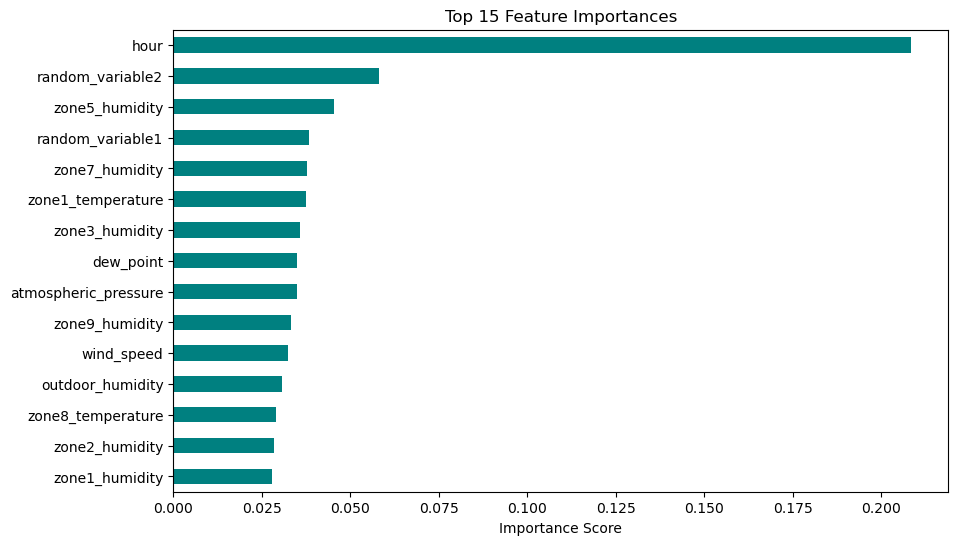

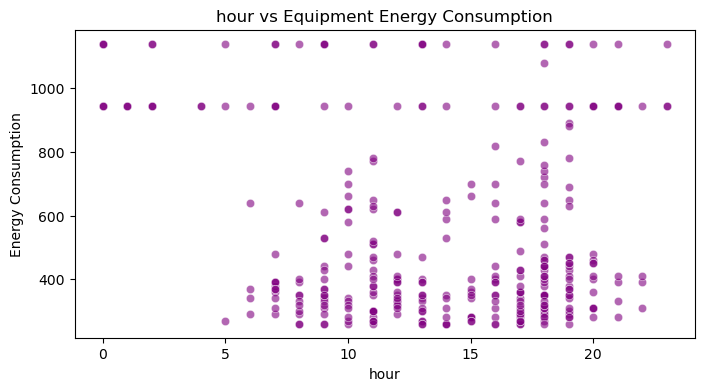

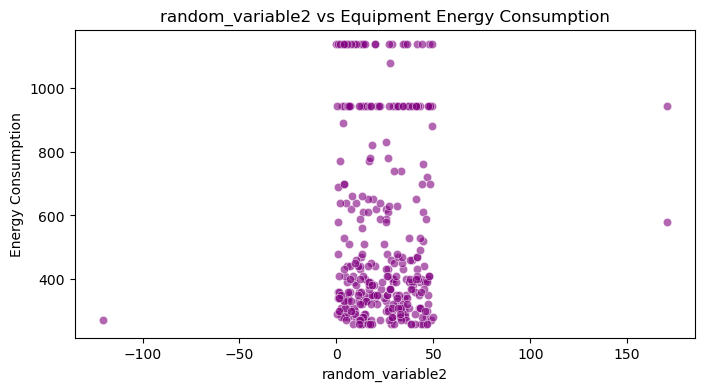

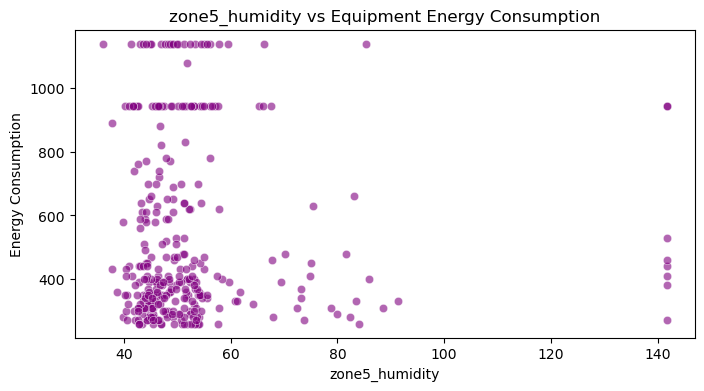

In [159]:
# 3. Feature Importance with Random Forest
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, 
                       index=X.columns).sort_values(ascending=False)
print("\nFeature Importances:")
print(importances.head(10))

# Plot feature importances
plt.figure(figsize=(10, 6))
importances.head(15).plot(kind='barh', color='teal')
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()

# 4. Top Features Visualization (Scatter Plots)
top_features = importances.head(3).index.tolist()

for feature in top_features:
    plt.figure(figsize=(8, 4))
    sns.scatterplot(data=df, x=feature, y='equipment_energy_consumption',
                    alpha=0.6, color='purple')
    plt.title(f'{feature} vs Equipment Energy Consumption')
    plt.ylabel('Energy Consumption')
    plt.savefig(f'{feature}_target.png')
    plt.show()

In [153]:
# ----------------------------------------------------------------
# 8. KEY INSIGHTS AND SUMMARY
# ----------------------------------------------------------------
print("\n KEY INSIGHTS AND SUMMARY")
print("-" * 70)
final_df = df
target = 'equipment_energy_consumption'
print("\n Target Variable Summary")
print(f"Mean energy consumption: {final_df[target].mean():.2f} Wh")
print(f"Median energy consumption: {final_df[target].median():.2f} Wh")
print(f"Minimum energy consumption: {final_df[target].min():.2f} Wh")
print(f"Maximum energy consumption: {final_df[target].max():.2f} Wh")
print(f"Standard deviation: {final_df[target].std():.2f} Wh")

print("\n Zone Analysis")
corr_matrix = final_df.select_dtypes(include=np.number).corr()
# Calculate average temperature and humidity by zone
zone_summary = []
for i in range(1, 10):
    temp_col = f'zone{i}_temperature'
    humid_col = f'zone{i}_humidity'
    avg_temp = final_df[temp_col].mean()
    avg_humid = final_df[humid_col].mean()
    temp_corr = corr_matrix.loc[temp_col, target]
    humid_corr = corr_matrix.loc[humid_col, target]
    zone_summary.append({
        'Zone': i,
        'Avg Temperature': avg_temp,
        'Avg Humidity': avg_humid,
        'Temp Correlation': temp_corr,
        'Humidity Correlation': humid_corr
    })

zone_df = pd.DataFrame(zone_summary)
print("\nZone Summary:")
print(zone_df)

print("\n Time Pattern Summary")
if 'hour' in df.columns:
    peak_hour = final_df.groupby('hour')[target].mean().idxmax()
    min_hour = final_df.groupby('hour')[target].mean().idxmin()
    print(f"Peak consumption hour: {peak_hour}:00")
    print(f"Minimum consumption hour: {min_hour}:00")

if 'weekday' in final_df.columns and final_df['weekday'].nunique() > 1:
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    peak_day = final_df.groupby('weekday')[target].mean().idxmax()
    min_day = final_df.groupby('weekday')[target].mean().idxmin()
    print(f"Peak consumption day: {days[peak_day]}")
    print(f"Minimum consumption day: {days[min_day]}")

if 'month' in final_df.columns and final_df['month'].nunique() > 1:
    months = ['January', 'February', 'March', 'April', 'May', 'June', 
              'July', 'August', 'September', 'October', 'November', 'December']
    peak_month = final_df.groupby('month')[target].mean().idxmax()
    min_month = final_df.groupby('month')[target].mean().idxmin()
    print(f"Peak consumption month: {months[peak_month-1]}")
    print(f"Minimum consumption month: {months[min_month-1]}")

if 'season' in final_df.columns and final_df['season'].nunique() > 1:
    peak_season = final_df.groupby('season')[target].mean().idxmax()
    min_season = final_df.groupby('season')[target].mean().idxmin()
    print(f"Peak consumption season: {peak_season}")
    print(f"Minimum consumption season: {min_season}")


 KEY INSIGHTS AND SUMMARY
----------------------------------------------------------------------

 Target Variable Summary
Mean energy consumption: 114.78 Wh
Median energy consumption: 60.00 Wh
Minimum energy consumption: 10.00 Wh
Maximum energy consumption: 1139.99 Wh
Standard deviation: 164.38 Wh

 Zone Analysis

Zone Summary:
   Zone  Avg Temperature  Avg Humidity  Temp Correlation  Humidity Correlation
0     1        21.215624     39.713041          0.041421              0.054418
1     2        19.797067     40.122210          0.051216              0.002055
2     3        21.690623     39.100406          0.023927              0.016700
3     4        20.173380     39.059046          0.035726              0.004114
4     5        19.005857     52.070447          0.011163              0.021132
5     6         6.437361     62.656003          0.046514             -0.045440
6     7        19.748082     35.183728          0.019108              0.000464
7     8        21.631906     43.1268

## enrgy range < 250

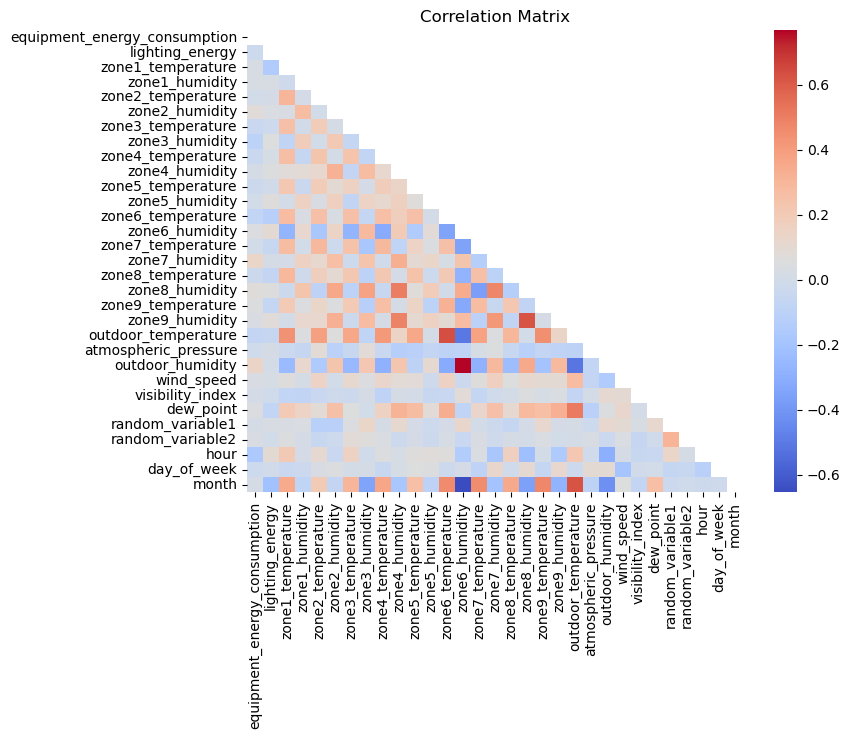


Top Correlated Features:
outdoor_humidity     0.139515
zone7_humidity       0.129377
zone2_humidity       0.075357
zone8_humidity       0.071302
zone9_temperature    0.050299
Name: equipment_energy_consumption, dtype: float64

Mutual Information Scores:
zone9_humidity          0.120430
hour                    0.112228
zone1_humidity          0.065765
zone8_temperature       0.062361
zone7_temperature       0.060177
zone5_temperature       0.057074
zone3_humidity          0.045022
atmospheric_pressure    0.043629
zone4_humidity          0.043500
zone8_humidity          0.041746
dtype: float64


In [39]:
df_maj = df[df[target] <= 250]


df_maj =high_energy_data.copy()
# Separate features and target
X = df_maj.drop('equipment_energy_consumption', axis=1)
y = df_maj['equipment_energy_consumption']

# 1. Correlation Analysis
corr_matrix = df_maj.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', 
            mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title('Correlation Matrix')
plt.show()

# Top correlated features with target
target_corr = corr_matrix['equipment_energy_consumption'].sort_values(ascending=False)
print("\nTop Correlated Features:")
print(target_corr[1:6])  # Exclude self-correlation

# 2. Mutual Information Analysis
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print("\nMutual Information Scores:")
print(mi_series.head(10))


Feature Importances:
hour                    0.208470
random_variable2        0.058085
zone5_humidity          0.045308
random_variable1        0.038283
zone7_humidity          0.037668
zone1_temperature       0.037483
zone3_humidity          0.035785
dew_point               0.035062
atmospheric_pressure    0.034947
zone9_humidity          0.033198
dtype: float64


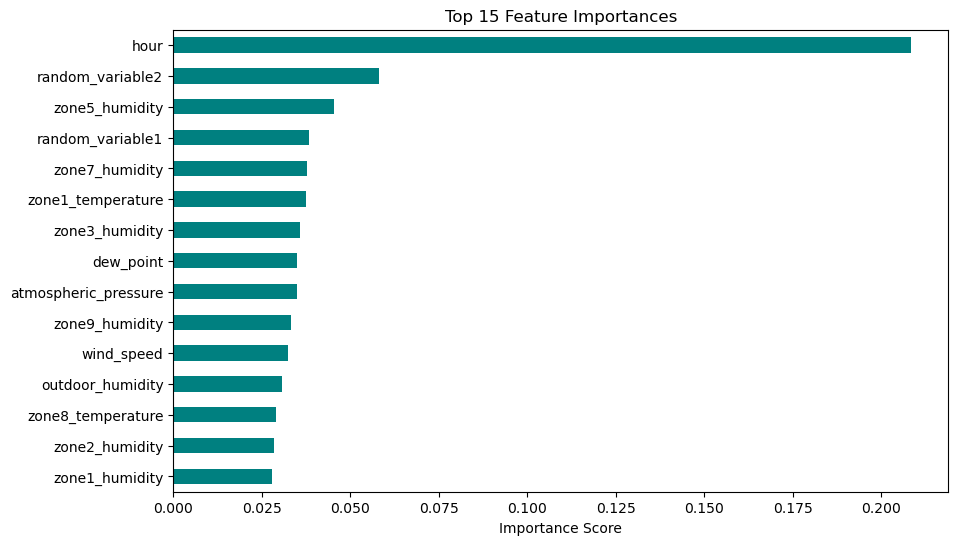

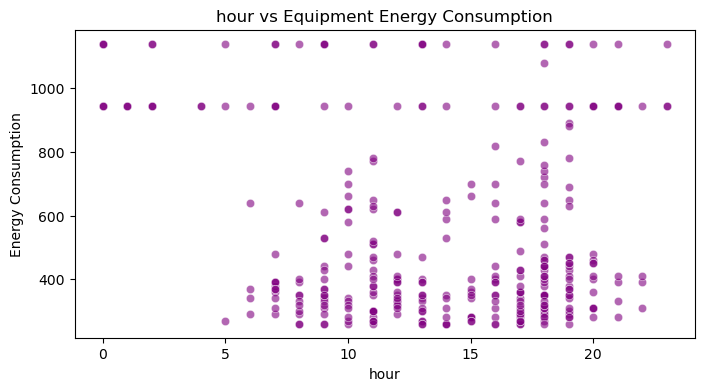

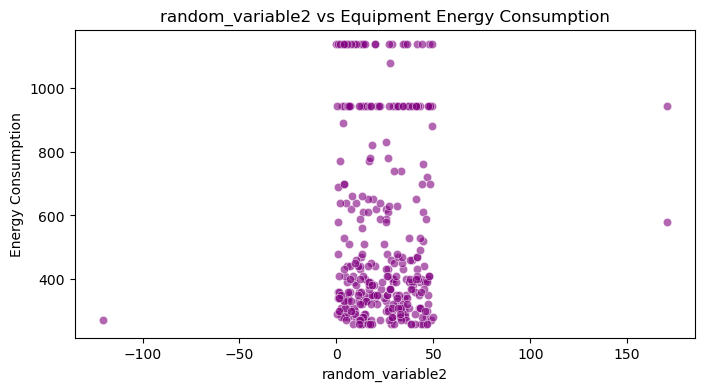

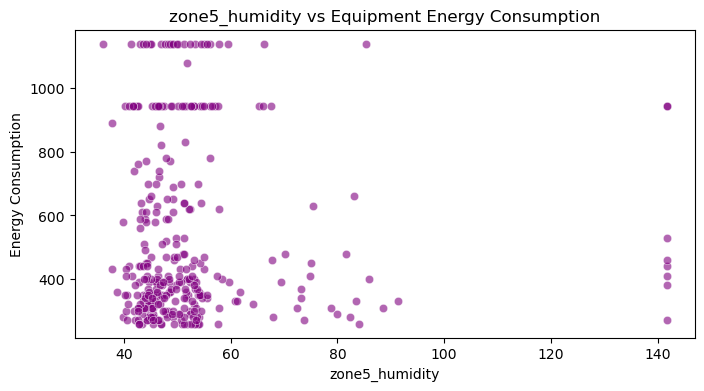

In [41]:
# 3. Feature Importance with Random Forest
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, 
                       index=X.columns).sort_values(ascending=False)
print("\nFeature Importances:")
print(importances.head(10))

# Plot feature importances
plt.figure(figsize=(10, 6))
importances.head(15).plot(kind='barh', color='teal')
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()

# 4. Top Features Visualization (Scatter Plots)
top_features = importances.head(3).index.tolist()

for feature in top_features:
    plt.figure(figsize=(8, 4))
    sns.scatterplot(data=df_maj, x=feature, y='equipment_energy_consumption',
                    alpha=0.6, color='purple')
    plt.title(f'{feature} vs Equipment Energy Consumption')
    plt.ylabel('Energy Consumption')
    plt.show()

In [71]:
df.shape

(16857, 31)

In [81]:
df[target] = pd.to_numeric(df[target])
df[target].dropna(inplace=True)
df[target].describe()

count    15945.000000
mean       117.082359
std        169.911547
min         10.000000
25%         50.000000
50%         60.000000
75%        100.000000
max       1139.985693
Name: equipment_energy_consumption, dtype: float64

In [87]:
df[target].quantile(0.90)

250.0